<a href="https://colab.research.google.com/github/abhilb/mycolab/blob/main/DetectSunglasses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
!ls drive/MyDrive/mydatasets

glasses_noGlasses  sunglasses.zip


In [51]:
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np

In [22]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_learning_rate = 0.0001

In [23]:
training_dir = Path('drive/MyDrive/mydatasets/glasses_noGlasses/train')
validation_dir  = Path('drive/MyDrive/mydatasets/glasses_noGlasses/valid')

# check if train and test data path exits
print(f"Training data dir exists: {training_dir.exists()}")
print(f"Test data dir exists    : {validation_dir.exists()}")

Training data dir exists: True
Test data dir exists    : True


In [24]:
train_dataset = tf.keras.utils.image_dataset_from_directory(training_dir,
                                                            label_mode='binary',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True)

Found 3251 files belonging to 2 classes.


In [25]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 label_mode='binary',
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 604 files belonging to 2 classes.


## Data augmentation


In [26]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

## Preprocess the image. 
Scale the image to the range -1,1

In [27]:
preprocess_input = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Get the base model
Using the mobilenetv2 as the base model

In [28]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [29]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_____________________________________________

In [32]:
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset)

Epoch 1/5
102/102 [==============================] - 16s 127ms/step - loss: 0.4093 - accuracy: 0.8213 - val_loss: 0.1410 - val_accuracy: 0.9967
Epoch 2/5
102/102 [==============================] - 12s 115ms/step - loss: 0.1093 - accuracy: 0.9892 - val_loss: 0.0635 - val_accuracy: 0.9950
Epoch 3/5
102/102 [==============================] - 12s 116ms/step - loss: 0.0618 - accuracy: 0.9945 - val_loss: 0.0415 - val_accuracy: 0.9950
Epoch 4/5
102/102 [==============================] - 12s 114ms/step - loss: 0.0423 - accuracy: 0.9951 - val_loss: 0.0318 - val_accuracy: 0.9950
Epoch 5/5
102/102 [==============================] - 12s 113ms/step - loss: 0.0324 - accuracy: 0.9960 - val_loss: 0.0266 - val_accuracy: 0.9950


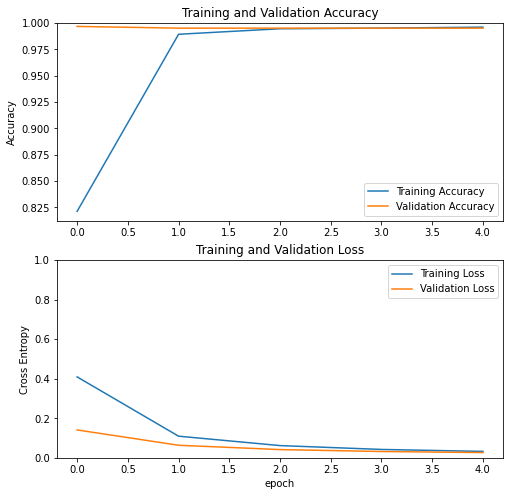

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
test_dataset = validation_dataset.take(1)
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 748ms/step - loss: 0.0218 - accuracy: 1.0000
Test accuracy : 1.0


[1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1]
[1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1]


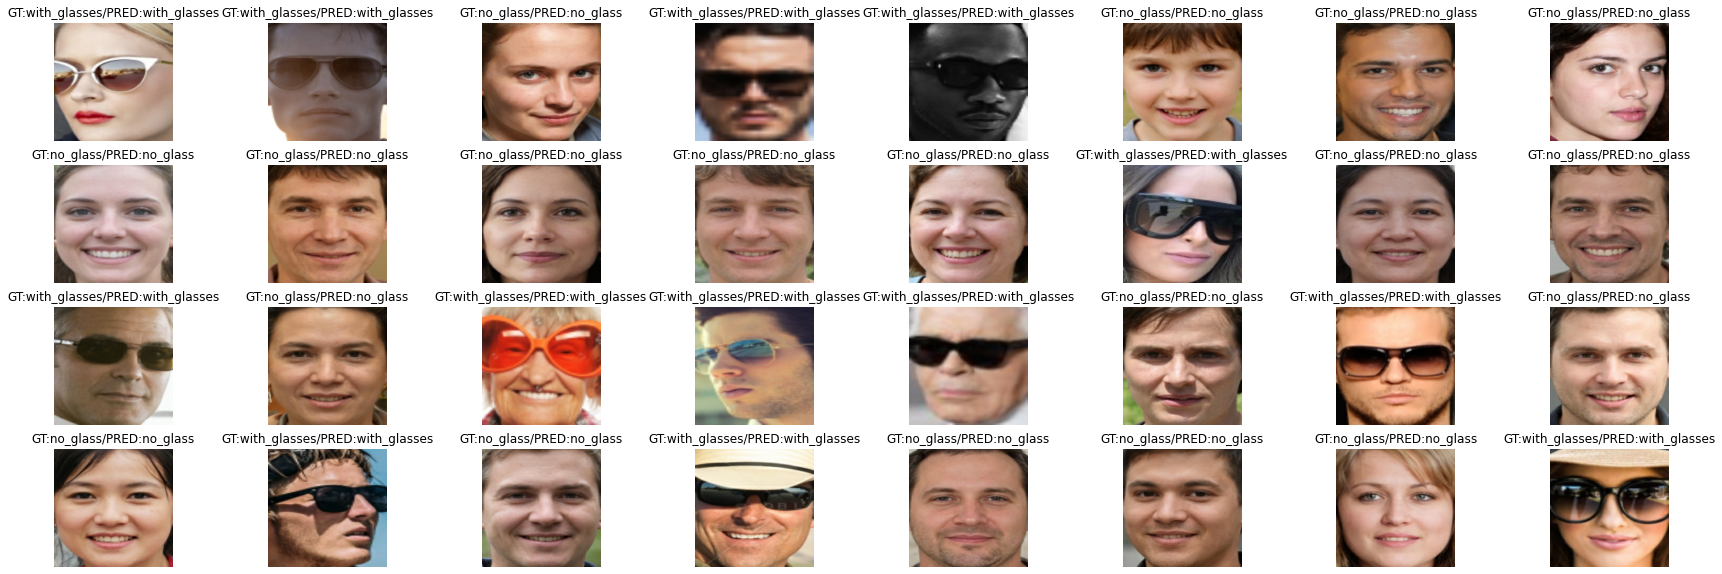

In [52]:
import numpy as np
figure = plt.figure(figsize=(30, 10))

for images, labels in test_dataset:
  num_of_images = images.shape[0]
  preds = np.argmax(model.predict(images), axis=1)
  print(preds)
  print(labels.numpy().flatten().astype(np.int8))
  for idx in range(num_of_images):
    image = images[idx].numpy().astype(np.uint8)
    ax = plt.subplot(4, 8, idx+1)
    ax.axis('off')
    gt = train_dataset.class_names[labels[idx].numpy().astype(np.uint8)[0]]
    pred = train_dataset.class_names[preds[idx]]
    ax.set_title(f'GT:{gt}/PRED:{pred}')
    ax.imshow(image)
plt.show()